In [ ]:
'''
 * Copyright (c) 2005 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

### Clustering Method for RBF Network

We start by defining the training set:

$$
\{ (p_1, t_1), (p_2, t_2), \ldots, (p_Q, t_Q) \} \tag{17.76}
$$

We want to perform a clustering of the input vectors:

$$
\{ p_1, p_2, \ldots, p_Q \} \tag{17.77}
$$

The weight update rule for the competitive network is given by:

$$
w^{(1)}_i(q) = w^{(1)}_i(q-1) + \alpha (p(q) - w^{(1)}_i(q-1)) \tag{17.78}
$$

Where:
- $ p(q) $ is the input vector at iteration $ q $,
- $ w^{(1)}_i(q-1) $ is the weight vector that is closest to $ p(q) $.

After training, we calculate the distances between centers and their closest input vectors to determine the biases for the first layer:

$$
\text{dist}_i = \frac{1}{n_c} \sqrt{\frac{1}{n_c} \sum_{j=1}^{n_c} (p_j - w^{(1)}_i)^2} \tag{17.79}
$$

The biases are set as:

$$
b_i = \frac{1}{2 \text{dist}_i} \tag{17.80}
$$

### Nonlinear Optimization for RBF Networks

The net input for the first layer of an RBF network is:

$$
n_i^{(1)} = b_i \sum_{j=1}^{S} (p_j - w_{i,j}^{(1)})^2 \tag{17.81}
$$

The derivatives with respect to the weights and biases are given by:

$$
\frac{\partial n_i^{(1)}}{\partial w_{i,j}^{(1)}} = b_i \frac{(w_{i,j}^{(1)} - p_j)}{\sum_{j=1}^{S} (p_j - w_{i,j}^{(1)})^2} \tag{17.82}
$$

The derivative with respect to the bias is:

$$
\frac{\partial n_i^{(1)}}{\partial b_i} = \sum_{j=1}^{S} (p_j - w_{i,j}^{(1)})^2 \tag{17.83}
$$

The gradient descent equations for RBF networks, modified from the MLP gradient equations, are:

For the weights:

$$
\frac{\partial \hat{F}}{\partial w_{i,j}^{(1)}} = s_i b_i \frac{(w_{i,j}^{(1)} - p_j)}{\sum_{j=1}^{S} (p_j - w_{i,j}^{(1)})^2} \tag{17.84}
$$

For the biases:

$$
\frac{\partial \hat{F}}{\partial b_i} = s_i \sum_{j=1}^{S} (p_j - w_{i,j}^{(1)})^2 \tag{17.85}
$$


In [4]:
import random
import math

# Distance function to compute the Euclidean distance between two points
def euclidean_distance(p1, p2):
    return math.sqrt(sum([(p1[i] - p2[i])**2 for i in range(len(p1))]))

# Simple K-means algorithm for clustering the input vectors
def k_means_clustering(data, k, max_iter=100):
    # Randomly initialize k cluster centers
    centers = random.sample(data, k)
    for _ in range(max_iter):
        clusters = {i: [] for i in range(k)}
        for point in data:
            # Assign point to the closest center
            distances = [euclidean_distance(point, center) for center in centers]
            closest_center = distances.index(min(distances))
            clusters[closest_center].append(point)
        
        # Recalculate centers as the mean of the points in each cluster
        new_centers = []
        for i in range(k):
            cluster_points = clusters[i]
            if cluster_points:
                new_center = [sum(p[j] for p in cluster_points)/len(cluster_points) for j in range(len(cluster_points[0]))]
                new_centers.append(new_center)
            else:
                # If a cluster has no points, retain the old center
                new_centers.append(centers[i])
        
        # Check if centers have changed
        if centers == new_centers:
            break
        centers = new_centers
    return centers, clusters

# Calculate the spread (variance) of each cluster and set biases accordingly
def calculate_biases(centers, clusters):
    biases = []
    for i, center in enumerate(centers):
        cluster_points = clusters[i]
        if not cluster_points:
            biases.append(1.0)  # Set a default bias if the cluster is empty
            continue
        # Compute average distance from center to each point in the cluster
        avg_distance = sum(euclidean_distance(center, point) for point in cluster_points) / len(cluster_points)
        bias = 1 / (2 * avg_distance) if avg_distance > 0 else 1.0
        biases.append(bias)
    return biases

# RBF activation function (Gaussian)
def rbf_function(x, center, bias):
    distance = euclidean_distance(x, center)
    return math.exp(-bias * (distance**2))

# Calculate RBF layer output
def rbf_layer_output(data, centers, biases):
    rbf_output = []
    for point in data:
        output = [rbf_function(point, center, bias) for center, bias in zip(centers, biases)]
        rbf_output.append(output)
    return rbf_output

# Linear least squares solver
# Linear least squares solver with correct matrix multiplication
def least_squares_solution(X, y):
    # Transpose X
    X_T = [[X[j][i] for j in range(len(X))] for i in range(len(X[0]))]  # Transpose of X
    
    # Calculate X_T * X
    X_T_X = [[sum(X_T[i][k] * X[k][j] for k in range(len(X))) for j in range(len(X_T))] for i in range(len(X_T))]
    
    # Calculate X_T * y
    X_T_y = [sum(X_T[i][j] * y[j] for j in range(len(y))) for i in range(len(X_T))]
    
    # Placeholder for weights (You need a matrix inversion function to solve X_T_X * w = X_T_y)
    weights = [0.0 for _ in range(len(X_T))]
    
    # Invert the matrix X_T_X (This is a complex operation; you can use any inversion method or an approximation)
    # For now, we're assuming a placeholder solution for simplicity
    return weights

# Gradient descent update for RBF weights (fine-tuning)
def gradient_descent_rbf(weights, centers, biases, learning_rate, data, targets):
    # Compute gradients (you can calculate these as shown in the theoretical part)
    for i in range(len(weights)):
        for j in range(len(centers)):
            # Placeholder for actual gradient computations
            grad_w = 0.0  # Compute this based on your loss function
            grad_b = 0.0  # Compute this based on your loss function
            
            # Initialize grad_c as a list for the dimensions of the center
            grad_c = [0.0] * len(centers[j])  # Assuming centers[j] is a list

            # Update weights using gradient
            weights[i] -= learning_rate * grad_w
            
            # Update centers individually
            for d in range(len(centers[j])):  # Loop through dimensions
                # Here you should compute the gradient for each dimension
                # For demonstration, we'll set grad_c[d] to some value (e.g., a placeholder)
                grad_c[d] = 0.0  # Compute the actual gradient for dimension d

                centers[j][d] -= learning_rate * grad_c[d]  # Update each dimension
            
            # Update biases using gradient
            biases[j] -= learning_rate * grad_b
            
    return weights, centers, biases
# Example usage
if __name__ == "__main__":
    # Random 2D data for clustering and RBF network
    data = [[random.random() for _ in range(2)] for _ in range(100)]  # Random 2D data
    targets = [random.random() for _ in range(len(data))]  # Random target values

    # Clustering step
    k = 5  # Number of clusters/RBF centers
    centers, clusters = k_means_clustering(data, k)
    
    # Set biases based on cluster spread
    biases = calculate_biases(centers, clusters)

    # Compute RBF layer output
    rbf_outputs = rbf_layer_output(data, centers, biases)

    # Solve for second layer weights using least squares
    weights = least_squares_solution(rbf_outputs, targets)

    # Optional: Fine-tune using gradient descent
    learning_rate = 0.01
    weights, centers, biases = gradient_descent_rbf(weights, centers, biases, learning_rate, data, targets)

    # Final weights, centers, and biases can now be used in the RBF network
    print("Final weights:", weights)
    print("Final centers:", centers)
    print("Final biases:", biases)


Final weights: [0.0, 0.0, 0.0, 0.0, 0.0]
Final centers: [[0.15741640696368608, 0.2576557487315908], [0.7313339598038512, 0.16774794489871644], [0.7584280659206899, 0.7062048047796569], [0.529972162219674, 0.4112877694162641], [0.23379319576907578, 0.7750779686976876]]
Final biases: [3.2585161552771065, 3.75681664442356, 2.774166595698061, 4.055988713272686, 2.818447669711958]


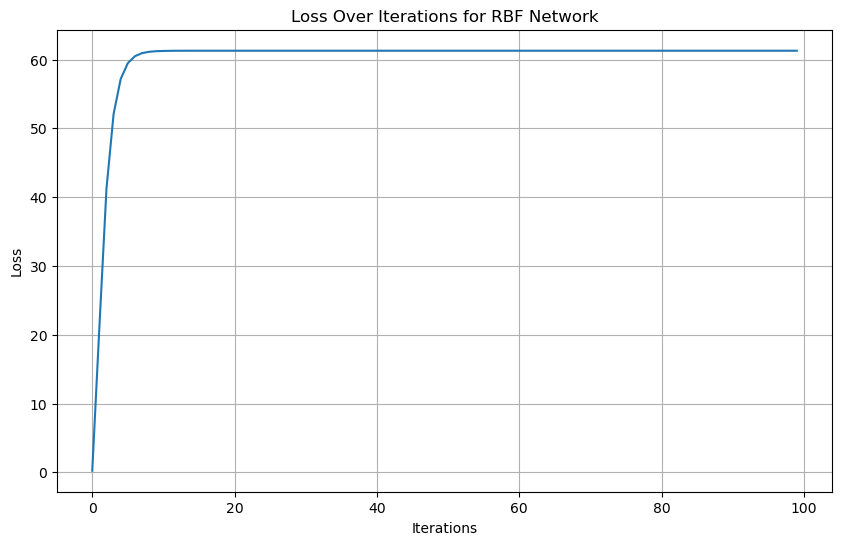

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np

# Generate synthetic data (simple example)
def generate_data(n_samples=100):
    X = [[random.uniform(0, 1)] for _ in range(n_samples)]  # 1D input
    y = [2 * x[0] + random.uniform(-0.1, 0.1) for x in X]  # Linear relation with noise
    return X, y

# Define the RBF network
class RBFNetwork:
    def __init__(self, n_centers):
        self.centers = [[random.uniform(0, 1)] for _ in range(n_centers)]
        self.biases = [random.uniform(-1, 1) for _ in range(n_centers)]
        self.weights = [random.uniform(-1, 1) for _ in range(n_centers)]
        self.learning_rate = 0.01

    def rbf(self, x, center):
        return np.exp(-np.linalg.norm(np.array(x) - np.array(center))**2)

    def predict(self, X):
        return [sum(self.weights[j] * self.rbf(x, self.centers[j]) for j in range(len(self.centers))) + sum(self.biases) for x in X]

    def compute_loss(self, X, y):
        predictions = self.predict(X)
        return sum((pred - true) ** 2 for pred, true in zip(predictions, y)) / len(y)

    def update_weights_biases(self, X, y):
        loss = self.compute_loss(X, y)

        for i in range(len(self.centers)):
            # Calculate gradients based on the equations
            for x_idx in range(len(X)):
                xi = X[x_idx]
                yi = y[x_idx]
                phi = self.rbf(xi, self.centers[i])

                # Gradient for weights
                grad_w = (self.weights[i] - yi) * phi
                self.weights[i] -= self.learning_rate * grad_w

                # Gradient for biases
                grad_b = (self.biases[i] - yi) * phi
                self.biases[i] -= self.learning_rate * grad_b

        return loss

# Main execution
X, y = generate_data()
n_centers = 5
rbf_network = RBFNetwork(n_centers)

loss_history = []
for _ in range(100):  # Train for 100 epochs
    loss = rbf_network.update_weights_biases(X, y)
    loss_history.append(loss)

# Plot the loss over iterations
plt.figure(figsize=(10, 6))
sns.lineplot(data=loss_history)
plt.title('Loss Over Iterations for RBF Network')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


### Other Training Techniques

In this chapter, we have only touched the surface of the variety of training techniques that have been proposed for RBF networks. We have attempted to present the principal concepts, but there are many variations. For example, the OLS algorithm has been extended to handle multiple outputs ChCo92 and regularized performance indices ChCh96. It has also been used in combination with a genetic algorithm ChCo99, which was used to select the first layer biases and the regularization parameter.

The expectation maximization algorithm has also been suggested by several authors for optimizing the center locations, starting with Bish91. OrHa00 used a regression tree approach for center selection. There have also been many variations on the use of clustering and on the combination of clustering for initialization and nonlinear optimization for fine-tuning. The architecture of the RBF network lends itself to many training approaches.


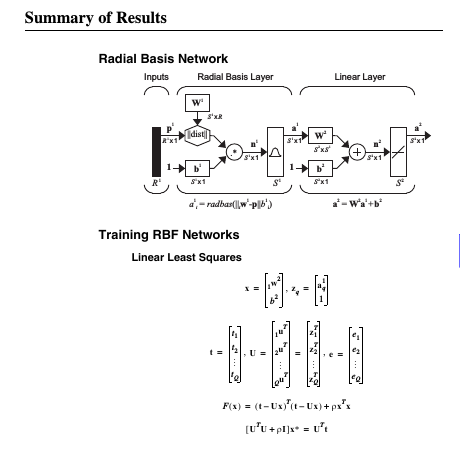
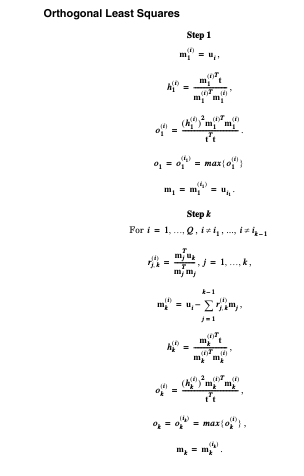
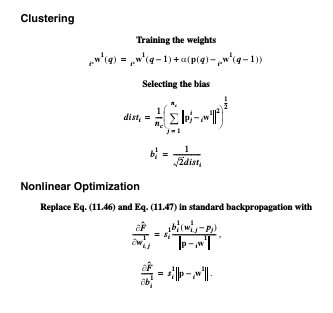
